In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from pathlib import Path
from tqdm import tqdm

In [2]:
def plot_waveform_whole(waveform, sample_rate, title):
    """
    绘制音频波形。

    参数:
    waveform (numpy.ndarray): 音频信号，形状为 (n_samples,)。
    sample_rate (int): 音频采样率，单位为 Hz。
    title (str, optional): 图表标题，默认值为 'Waveform'。
    """
    # 计算时间轴
    time_scale = np.linspace(0, len(waveform) / sample_rate, len(waveform))


    # 绘制波形
    plt.figure(figsize=(12, 8))
    plt.plot(time_scale, waveform)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.show()

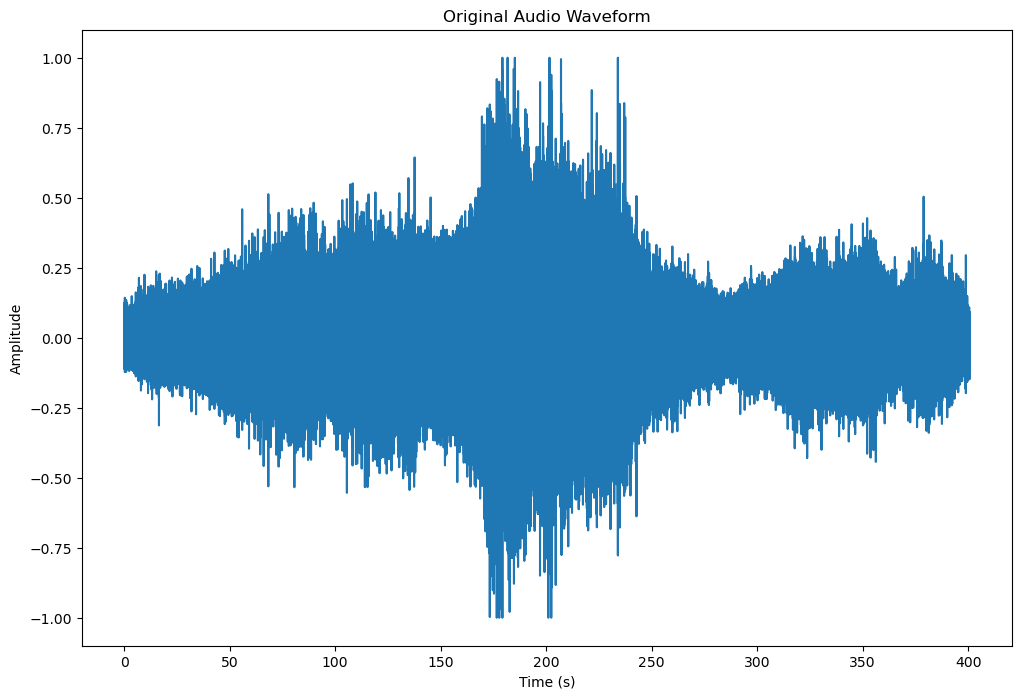

In [3]:
audio_file = r"E:\数据集\ShipEar\shipsEar_AUDIOS\69__23_07_13_H2_costaVoyager.wav"
waveform, sample_rate = librosa.load(audio_file, sr=None)

plot_waveform_whole(waveform, sample_rate, title="Original Audio Waveform")

In [4]:
def plot_waveform_segment(waveform, start_time, sample_rate, title):
    """
    绘制音频波形。

    参数:
    waveform (numpy.ndarray): 音频信号，形状为 (n_samples,)。
    sample_rate (int): 音频采样率，单位为 Hz。
    title (str, optional): 图表标题，默认值为 'Waveform'。
    """
    # 计算时间轴
    time_offset = start_time
    time_scale = np.linspace(time_offset, time_offset + len(waveform) / sample_rate, len(waveform))


    # 绘制波形
    plt.figure(figsize=(16, 8))
    plt.plot(time_scale, waveform)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.show()

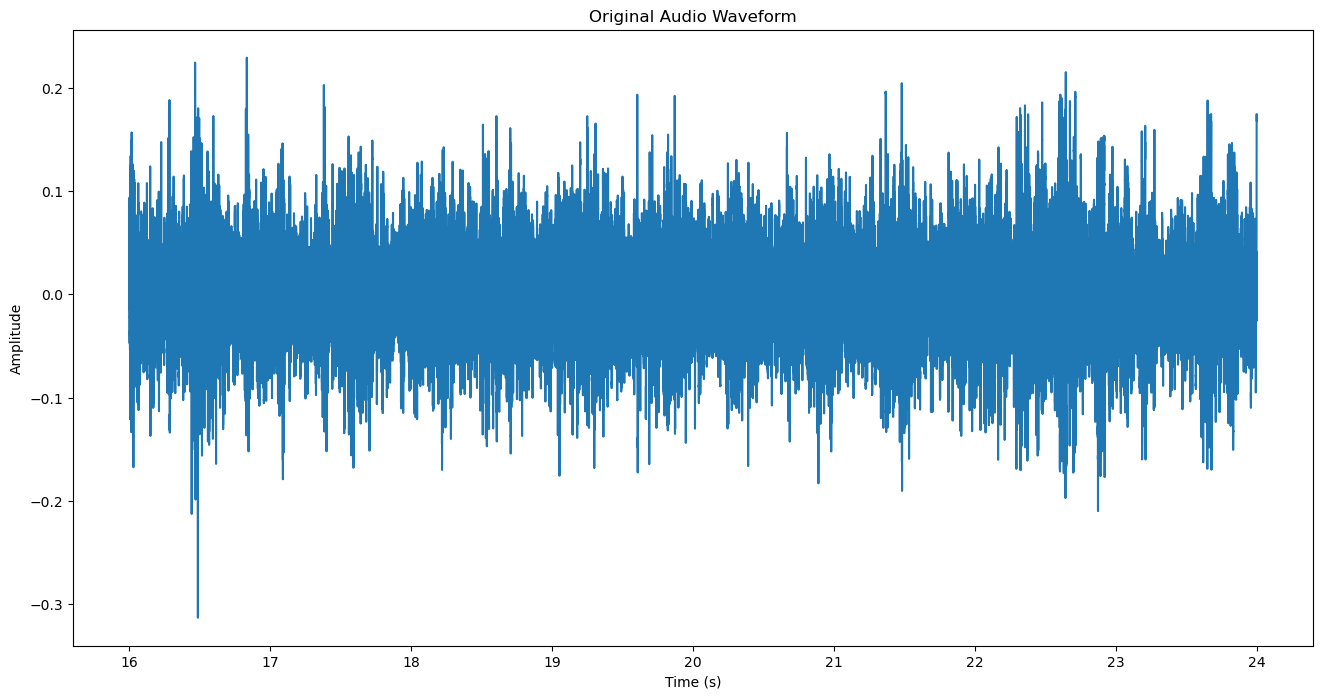

In [5]:
audio_file = r"E:\数据集\ShipEar\shipsEar_AUDIOS\69__23_07_13_H2_costaVoyager.wav"
waveform, sample_rate = librosa.load(audio_file, sr=None)

start_time = 16 
segment_duration = 8
segment_samples = int(sample_rate * segment_duration)
start_sample = int(start_time * sample_rate)
end_sample = start_sample + segment_samples
segment = waveform[start_sample:end_sample]

plot_waveform_segment(segment, start_time, sample_rate, title='Original Audio Waveform')

In [6]:
def add_noise_with_snr(signal, target_snr_db, random_seed=42):
    """
    添加噪声以达到目标信噪比（SNR）。

    参数:
    signal (numpy.ndarray): 原始音频信号。
    target_snr_db (float): 目标信噪比（分贝）。

    返回:
    numpy.ndarray: 添加噪声后的音频信号。
    """
    rng = np.random.default_rng(random_seed)
    # 计算信号的功率
    signal_power = np.mean(signal ** 2)

    # 将 SNR 从 dB 转换为线性值
    snr_linear = 10 ** (target_snr_db / 10.0)

    # 计算所需的噪声功率 P_N
    noise_power = signal_power / snr_linear

    # 生成高斯白噪声
    noise = rng.normal(0, np.sqrt(noise_power), signal.shape)

    # 添加噪声
    noisy_signal = signal + noise

    snr_measured = 10 * np.log10(signal_power / np.mean(noise ** 2))

    return noisy_signal, snr_measured

Measured SNR: 10.00 dB


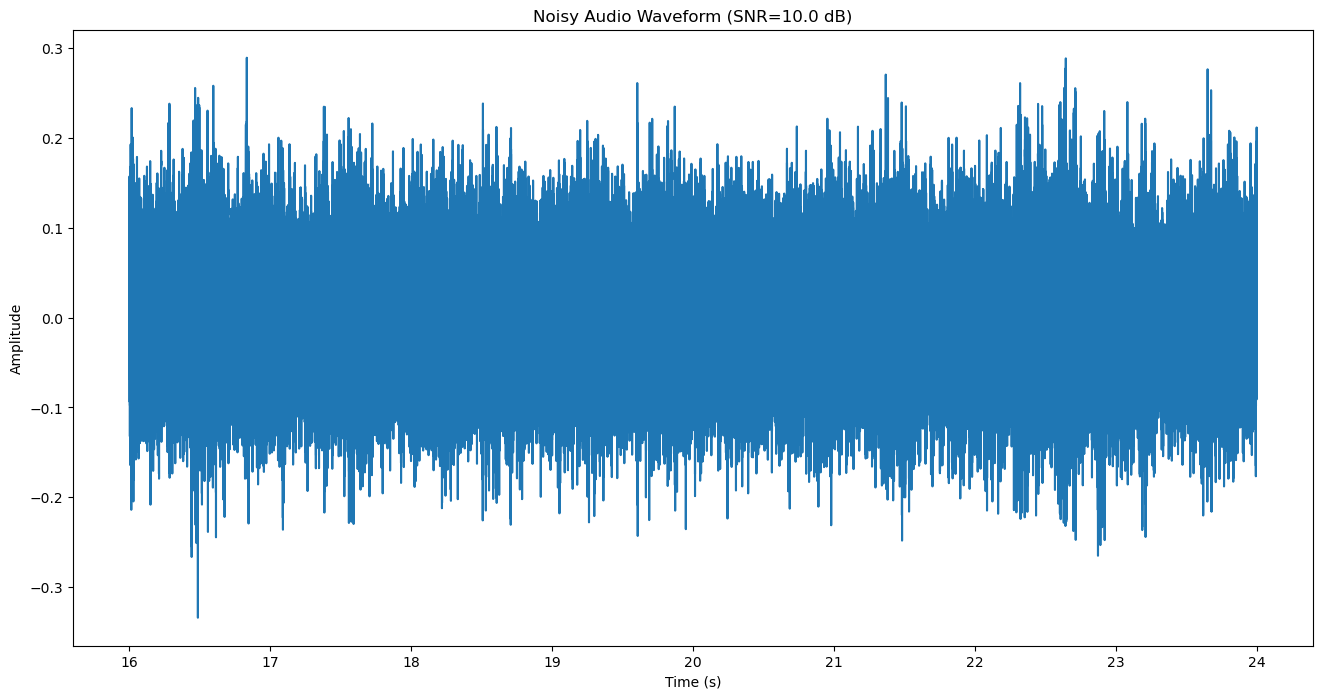

In [8]:
# 目标信噪比，可调节
snr_db = 10.0

noisy_waveform, snr_measured = add_noise_with_snr(waveform, snr_db)
print(f"Measured SNR: {snr_measured:.2f} dB")

start_time = 16 
segment_duration = 8
segment_samples = int(sample_rate * segment_duration)
start_sample = int(start_time * sample_rate)
end_sample = start_sample + segment_samples
segment = noisy_waveform[start_sample:end_sample]

plot_waveform_segment(segment, start_time, sample_rate, title=f'Noisy Audio Waveform (SNR={snr_db} dB)')

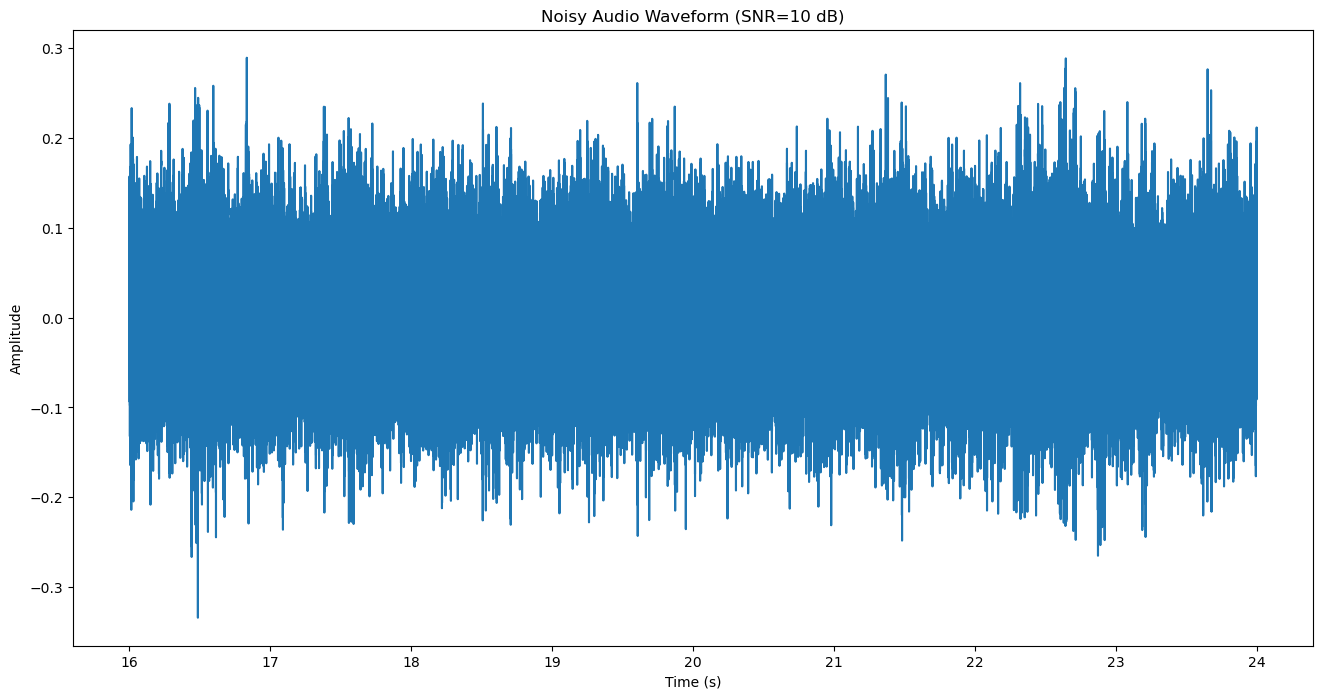

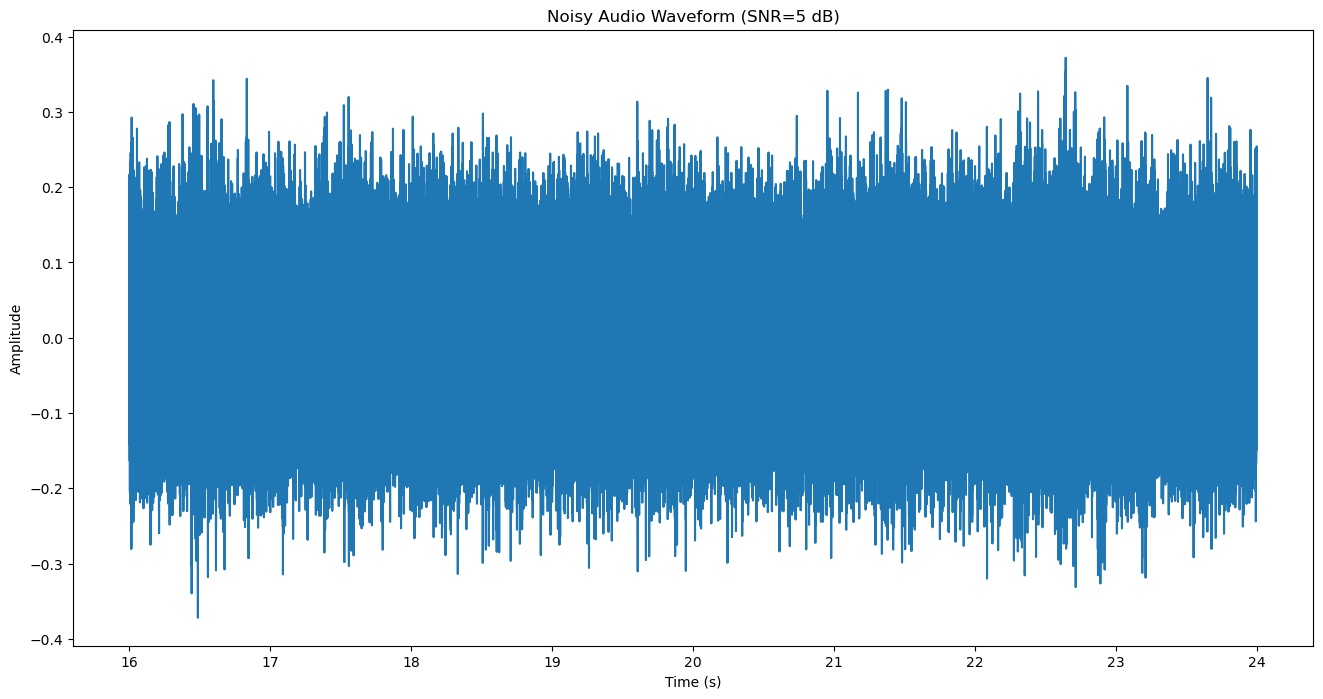

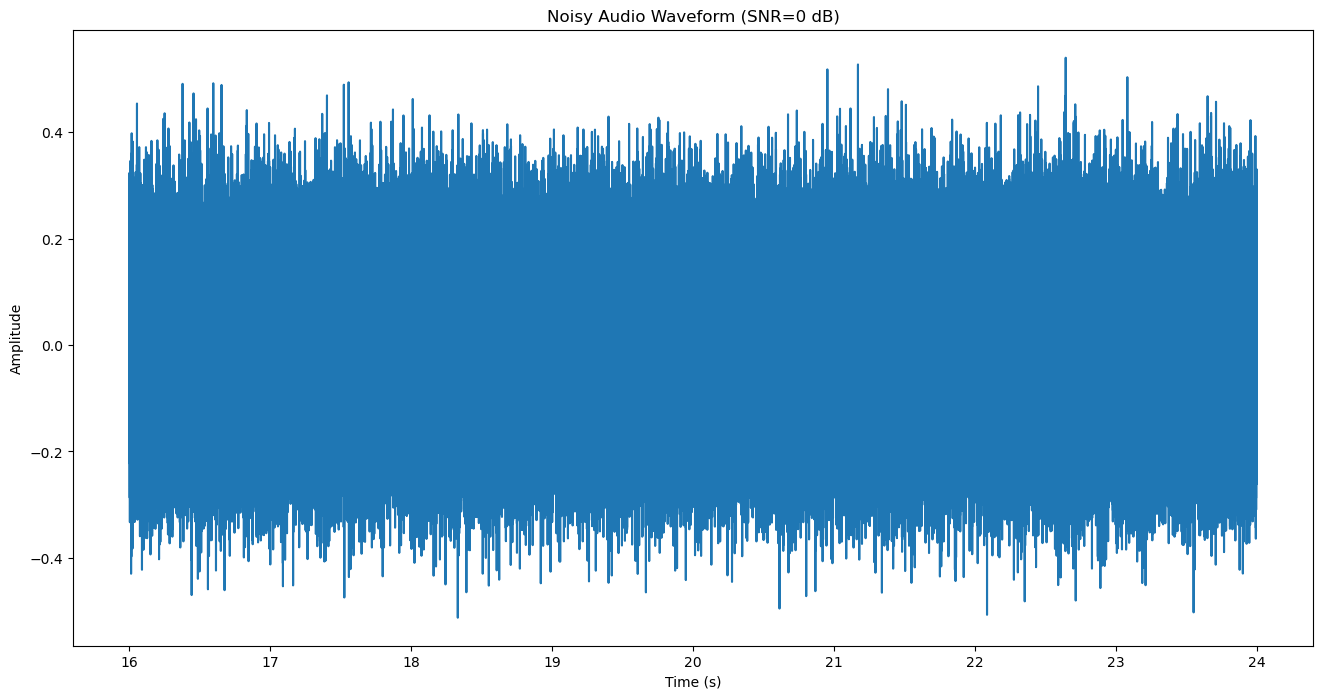

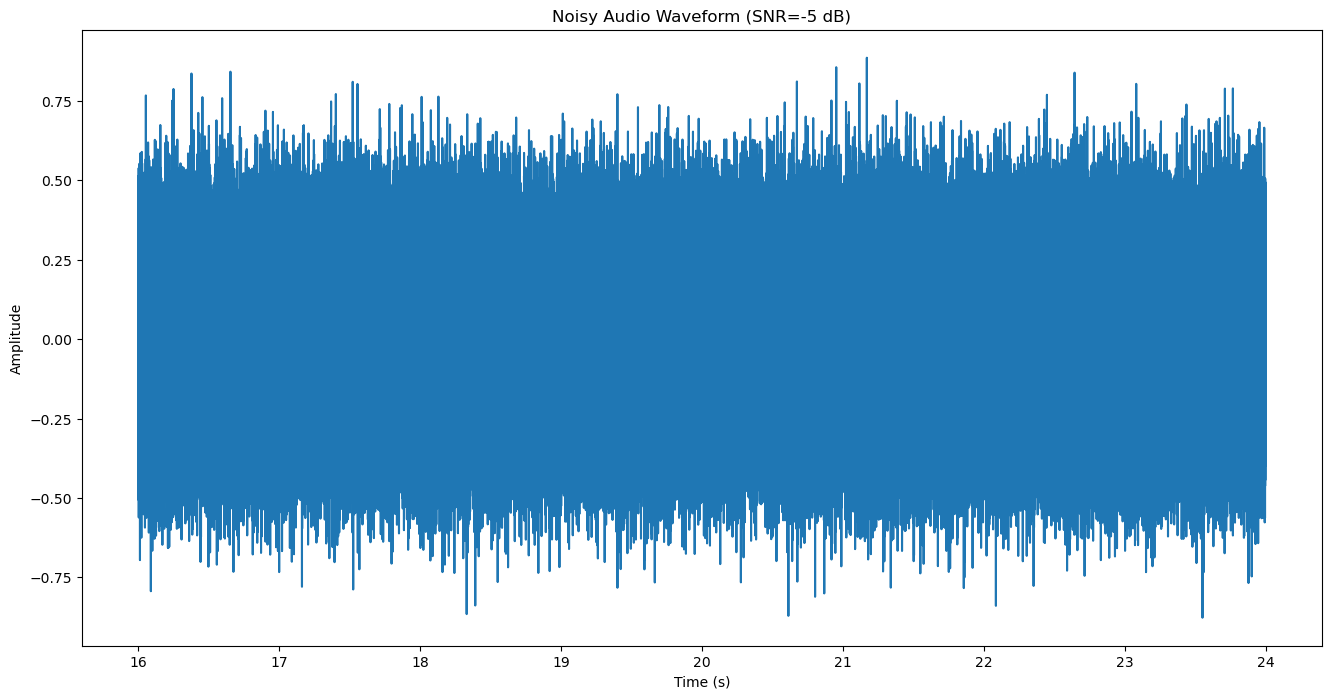

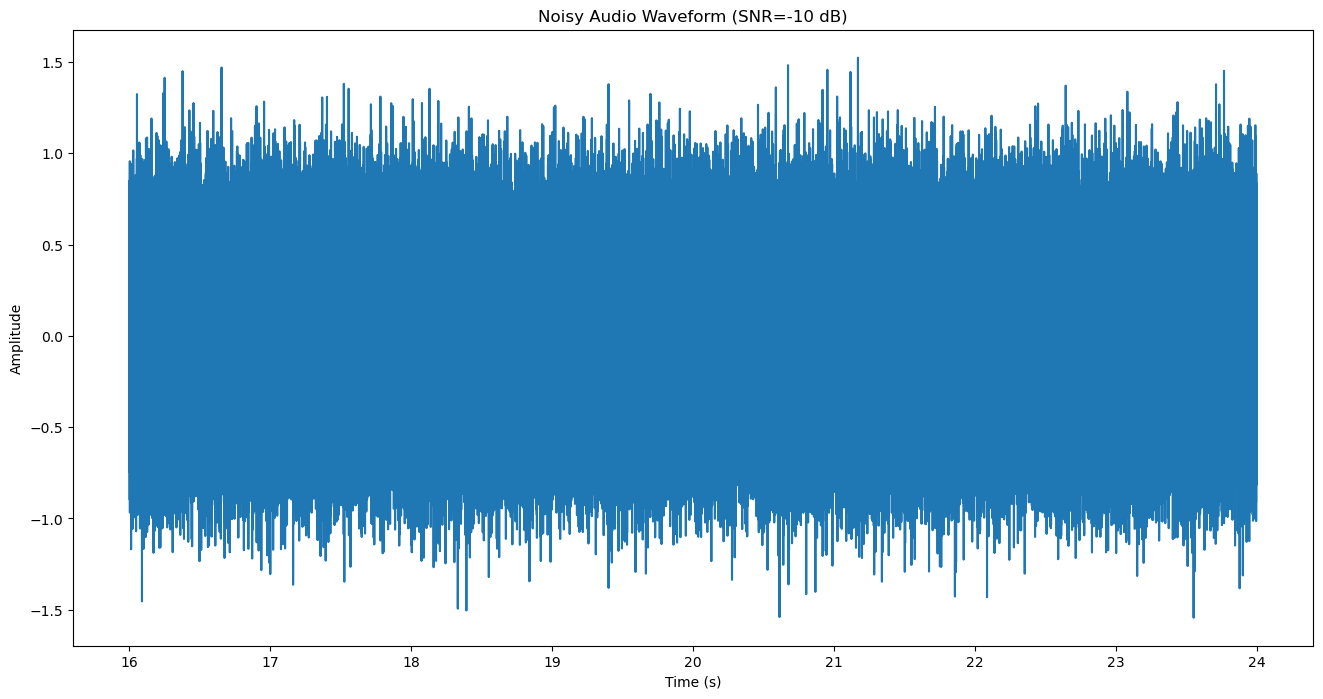

In [9]:
snr_levels = [10, 5, 0, -5, -10] 
plots = []

for snr_db in snr_levels:
    noisy_waveform, _ = add_noise_with_snr(waveform, snr_db)
    
    start_time = 16 
    segment_duration = 8
    segment_samples = int(sample_rate * segment_duration)
    start_sample = int(start_time * sample_rate)
    end_sample = start_sample + segment_samples
    segment = noisy_waveform[start_sample:end_sample]
    
    plots.append((segment, start_time, sample_rate, f'Noisy Audio Waveform (SNR={snr_db} dB)'))

# 创建子图
for plot in plots:
    segment, start_time, sample_rate, title = plot
    plot_waveform_segment(segment, start_time, sample_rate, title)

In [10]:
INPUT_DIR = Path(r"X:\数据集\ShipEar\shipsEar_AUDIOS")
OUTPUT_ROOT = Path(r"E:\数据集\ShipEar\data_preprocessing\12_pre-emphasis_add_gaussian_noise")
SNR_VALUES = [10, 5, 0, -5, -10] 

def process_all_files():
    wav_files = list(INPUT_DIR.rglob("*.wav"))
    if not wav_files:
        print(f"No wav files found under {INPUT_DIR}")
        return
    for snr_db in SNR_VALUES:
        dest_dir = OUTPUT_ROOT / f"SNR_{snr_db}dB"
        for wav_path in tqdm(wav_files, desc=f"SNR {snr_db:+d} dB"):
            relative_path = wav_path.relative_to(INPUT_DIR)
            output_path = dest_dir / relative_path
            output_path.parent.mkdir(parents=True, exist_ok=True)

            waveform, sample_rate = librosa.load(wav_path, sr=None)
            noisy_waveform, measured_snr = add_noise_with_snr(waveform, snr_db)

            sf.write(output_path, noisy_waveform, sample_rate)
            
process_all_files()

SNR -10 dB: 100%|██████████| 90/90 [00:10<00:00,  8.44it/s]


# 降噪

In [22]:
from pathlib import Path
import soundfile as sf
import noisereduce as nr
import scipy.signal as signal

In [18]:
def denoise_spectral_gate(waveform, sample_rate, stationary, y_noise, n_fft, hop_length, time_mask_smooth_ms, freq_mask_smooth_hz, prop_decrease):
    """
    对输入的音频信号进行频谱门限去噪。

    参数:
    waveform (numpy.ndarray): 输入音频信号。
    sample_rate (int): 音频信号的采样率。
    n_fft (int): FFT窗口大小。
    hop (int): 帧移大小。
    win (str): 窗口类型。
    noise_quantile (float): 噪声量化值。
    reduce_db (float): 减少的分贝值。
    floor_db (float): 下限的分贝值。
    beta (float): 门限系数。

    返回:
    numpy.ndarray: 去噪后的音频信号。
    """
    denoised_waveform = nr.reduce_noise(waveform, sample_rate, stationary=stationary, y_noise=y_noise, n_fft=n_fft, hop_length=hop_length, time_mask_smooth_ms=time_mask_smooth_ms, freq_mask_smooth_hz=freq_mask_smooth_hz, prop_decrease=prop_decrease)
    return denoised_waveform

def process_folder(input_folder, output_folder):
    # 确保输出文件夹存在，没有的话自动创建
    os.makedirs(output_folder, exist_ok=True)
    # 处理输入文件夹中的所有 WAV 文件
    for file in os.listdir(input_folder):
        if file.endswith(".wav"):
            input_file_path = os.path.join(input_folder, file)
            output_file_path = os.path.join(output_folder, file)

            waveform, sample_rate = librosa.load(input_file_path, sr=None)
            y_noise = waveform[:int(0.5 * sample_rate)]
            
            # 执行去噪函数
            denoised_waveform = denoised_signal = denoise_spectral_gate(
                    waveform, 
                    sample_rate, 
                    stationary=True, 
                    y_noise=y_noise,
                    n_fft=4096, 
                    hop_length=512, 
                    time_mask_smooth_ms=80, 
                    freq_mask_smooth_hz=400, 
                    prop_decrease=0.8, 
                )
            # 保存去噪后的音频
            sf.write(output_file_path, denoised_waveform, sample_rate)
            print(f"{file} processed and saved.")
        else:
            print(f"{file} is not a WAV file.")
    print("All files processed.")


In [19]:
root = Path(r"X:\数据集\ShipEar\data_preprocessing\12_pre-emphasis_add_gaussian_noise")
snr_dirs = ["SNR_10dB", "SNR_5dB", "SNR_0dB", "SNR_-5dB", "SNR_-10dB"]

for snr_name in snr_dirs:
    input_folder = root / snr_name
    output_folder = input_folder
    process_folder(input_folder, output_folder)

10__10_07_13_marDeOnza_Sale.wav processed and saved.
11__10_07_13_minhoUno_Entra.wav processed and saved.
12__10_07_13_minhoUno_Sale.wav processed and saved.
13__10_07_13_piraCies_Entra.wav processed and saved.
14__10_07_13_piraCies_Espera.wav processed and saved.
15__10_07_13_radaUno_Pasa.wav processed and saved.
16__10_07_13_mscOpera_InicioSalida.wav processed and saved.
17__10_07_13_visionSub_Entra.wav processed and saved.
18__18_07_13_AutoPrideEntra.wav processed and saved.
19__18_07_13_AutoprideMarchaAtras.wav processed and saved.
20__18_07_13_AutopridePrepManiobra.wav processed and saved.
21__18_07_13_lanchaMotora.wav processed and saved.
22__19_07_13_adventure_maniobra.wav processed and saved.
23__19_07_13_adventure_parado.wav processed and saved.
24__19_07_13_adventureFrenando_duda.wav processed and saved.
25__19_07_13_adventureOfTheSea_llegando.wav processed and saved.
26__19_07_13_Lancha.wav processed and saved.
27__19_07_13_Lancha2.wav processed and saved.
28__19_07_13_Nuevo

# 归一化与去中心化

In [20]:
def normalize_and_center(audio):
    # 最大幅度，做归一化
    max_amp = np.max(np.abs(audio))
    if max_amp > 0:
        normalized_audio = audio / max_amp
    else:
        normalized_audio = audio
    # 去中心化
    normalized_center_audio = normalized_audio - normalized_audio.mean()
    return normalized_center_audio

In [21]:
root = Path(r"X:\数据集\ShipEar\data_preprocessing\12_pre-emphasis_add_gaussian_noise")
snr_dirs = ["SNR_10dB", "SNR_5dB", "SNR_0dB", "SNR_-5dB", "SNR_-10dB"]

for snr_name in snr_dirs:
    snr_folder = root / snr_name
    for wav_path in snr_folder.rglob("*.wav"):
        audio, sr = librosa.load(wav_path, sr=None)
        processed = normalize_and_center(audio)
        sf.write(wav_path, processed, sr)
        print(f"[覆写] {wav_path}")

[覆写] X:\数据集\ShipEar\data_preprocessing\12_pre-emphasis_add_gaussian_noise\SNR_10dB\10__10_07_13_marDeOnza_Sale.wav
[覆写] X:\数据集\ShipEar\data_preprocessing\12_pre-emphasis_add_gaussian_noise\SNR_10dB\11__10_07_13_minhoUno_Entra.wav
[覆写] X:\数据集\ShipEar\data_preprocessing\12_pre-emphasis_add_gaussian_noise\SNR_10dB\12__10_07_13_minhoUno_Sale.wav
[覆写] X:\数据集\ShipEar\data_preprocessing\12_pre-emphasis_add_gaussian_noise\SNR_10dB\13__10_07_13_piraCies_Entra.wav
[覆写] X:\数据集\ShipEar\data_preprocessing\12_pre-emphasis_add_gaussian_noise\SNR_10dB\14__10_07_13_piraCies_Espera.wav
[覆写] X:\数据集\ShipEar\data_preprocessing\12_pre-emphasis_add_gaussian_noise\SNR_10dB\15__10_07_13_radaUno_Pasa.wav
[覆写] X:\数据集\ShipEar\data_preprocessing\12_pre-emphasis_add_gaussian_noise\SNR_10dB\16__10_07_13_mscOpera_InicioSalida.wav
[覆写] X:\数据集\ShipEar\data_preprocessing\12_pre-emphasis_add_gaussian_noise\SNR_10dB\17__10_07_13_visionSub_Entra.wav
[覆写] X:\数据集\ShipEar\data_preprocessing\12_pre-emphasis_add_gaussian_noise\

# 预加重

In [23]:
alpha = 0.97
root = Path(r"X:\数据集\ShipEar\data_preprocessing\12_pre-emphasis_add_gaussian_noise")
snr_dirs = ["SNR_10dB", "SNR_5dB", "SNR_0dB", "SNR_-5dB", "SNR_-10dB"]

for snr_name in snr_dirs:
    snr_folder = root / snr_name
    for wav_path in snr_folder.rglob("*.wav"):
        audio, sr = librosa.load(wav_path, sr=None)

        # 计算预加重系数
        pre_emphasis = np.array([1, -alpha])
        audio_data_pre_emphasis = signal.lfilter(pre_emphasis, 1, audio)
        
        sf.write(wav_path, audio_data_pre_emphasis, sr)
        print(f"[覆写] {wav_path}")

[覆写] X:\数据集\ShipEar\data_preprocessing\12_pre-emphasis_add_gaussian_noise\SNR_10dB\10__10_07_13_marDeOnza_Sale.wav
[覆写] X:\数据集\ShipEar\data_preprocessing\12_pre-emphasis_add_gaussian_noise\SNR_10dB\11__10_07_13_minhoUno_Entra.wav
[覆写] X:\数据集\ShipEar\data_preprocessing\12_pre-emphasis_add_gaussian_noise\SNR_10dB\12__10_07_13_minhoUno_Sale.wav
[覆写] X:\数据集\ShipEar\data_preprocessing\12_pre-emphasis_add_gaussian_noise\SNR_10dB\13__10_07_13_piraCies_Entra.wav
[覆写] X:\数据集\ShipEar\data_preprocessing\12_pre-emphasis_add_gaussian_noise\SNR_10dB\14__10_07_13_piraCies_Espera.wav
[覆写] X:\数据集\ShipEar\data_preprocessing\12_pre-emphasis_add_gaussian_noise\SNR_10dB\15__10_07_13_radaUno_Pasa.wav
[覆写] X:\数据集\ShipEar\data_preprocessing\12_pre-emphasis_add_gaussian_noise\SNR_10dB\16__10_07_13_mscOpera_InicioSalida.wav
[覆写] X:\数据集\ShipEar\data_preprocessing\12_pre-emphasis_add_gaussian_noise\SNR_10dB\17__10_07_13_visionSub_Entra.wav
[覆写] X:\数据集\ShipEar\data_preprocessing\12_pre-emphasis_add_gaussian_noise\